# 데이터 셋 만들기

1. iso 표준 데이터 다운로드

2. iso 표준 데이터에 맞춰 kaggle에서 받은 국가별 확진자 데이터의 국가명을 국가코드로 변경
    - 이 과정에서 iso 표준의 국가명과 괄호 또는 영문표기 등으로 맞지 않는 60여개의 국가는 수기로 변경
    - 코소보는 검색을 통해 XK로 변경
    - 데이터에 Diamond Princess, MS Zaandam, West Bank and Gaza 와 같은 국가가 아닌 발병지가 있어서 삭제
3. 공모전에서 제공하는 roamming 데이터를 iso 별로 일일 로밍 수 생성

4. 데이터 통합

In [227]:
import pandas as pd
import numpy as np

# 1. iso 표준 데이터

In [228]:
iso = pd.read_csv('./data/iso.csv')

In [229]:
# covide-19 글로벌 kaggle 데이터
kag = pd.read_csv('./data/corona-virus-report/covid_19_clean_complete.csv')
kag['Date'] = pd.to_datetime(kag['Date'])

In [230]:
kag.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27720 entries, 0 to 27719
Data columns (total 8 columns):
Province/State    8400 non-null object
Country/Region    27720 non-null object
Lat               27720 non-null float64
Long              27720 non-null float64
Date              27720 non-null datetime64[ns]
Confirmed         27720 non-null int64
Deaths            27720 non-null int64
Recovered         27720 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 1.7+ MB


In [231]:
pivoted_kag = kag.pivot_table(index='Date', columns='Country/Region', values = 'Confirmed', aggfunc='sum')

In [232]:
col_list = list(pivoted_kag.columns)

In [233]:
iso.head()

,English short name,Alpha-2 code,Numeric
0,Afghanistan,AF,4.0
1,Albania,AL,8.0
2,Algeria,DZ,12.0
3,American Samoa,AS,16.0
4,Andorra,AD,20.0


In [234]:
tmp = []
iso_list = list(iso['English short name'])
iso_code_list = list(iso['Alpha-2 code'])
for i in col_list:
    if i in iso_list:
        index_num = iso_list.index(i)
        pivoted_kag['{}'.format(iso_code_list[index_num])] = pivoted_kag[i]
        pivoted_kag.drop([i], axis=1, inplace=True)
        
    else:
        tmp.append(i)

In [235]:
# 맞지 않는 국가 코드 딕셔너리 생성
etc_dict = {
 'Bahamas' : 'BS',
 'Bolivia' : 'BO',
 'Brunei' : 'BN',
 'Burma' : 'MM',
 'Central African Republic' : 'CF',
 'Comoros' : 'KM',
 'Congo (Brazzaville)' : 'CG',
 'Congo (Kinshasa)' : 'CD',
 "Cote d'Ivoire" : 'CI',
 'Dominican Republic' : 'DO',
 'Gambia' : 'GM',
 'Holy See' : 'VA',
 'Iran' : 'IR',
 'Kosovo' : 'XK',
 'Laos' : 'LA',
 'Moldova' : 'MD',
 'Netherlands' : 'NL',
 'Niger' : 'NE',
 'Philippines' : 'PH',
 'Russia' : 'RU',
 'South Korea' : 'KR',
 'Sudan' : 'SS',
 'Syria' : 'SY',
 'Taiwan*' : 'TW',
 'Tanzania' : 'TZ',
 'US' : 'US',
 'United Arab Emirates':'AE',
 'United Kingdom':'GB',
 'Venezuela':'VE',
 'Vietnam':'VN',
}

In [236]:
pivoted_kag.rename(columns=etc_dict, inplace=True)

In [237]:
pivoted_kag.drop(['Diamond Princess', 'MS Zaandam', 'West Bank and Gaza'], axis=1, inplace=True)

In [238]:
last_cols = list(pivoted_kag.columns)

In [239]:
# 일일 별 확진자 수로 컬럼 변경
for i in last_cols:
    pivoted_kag[i] = pivoted_kag[i].diff()

In [240]:
pivoted_kag.reset_index(inplace=True)

In [241]:
pivoted_kag.iloc[0,1:] = 0

In [242]:
pivoted_kag.tail()

Country/Region,Date,BS,BO,BN,MM,CF,KM,CG,CD,CI,...,TN,TR,UG,UA,UY,UZ,EH,YE,ZM,ZW
100,2020-05-01,0.0,119.0,0.0,0.0,22.0,0.0,9.0,32.0,58.0,...,4.0,2188.0,2.0,455.0,5.0,47.0,0.0,1.0,3.0,0.0
101,2020-05-02,2.0,0.0,0.0,0.0,0.0,2.0,0.0,70.0,29.0,...,11.0,1983.0,3.0,550.0,4.0,32.0,0.0,3.0,10.0,-6.0
102,2020-05-03,0.0,365.0,0.0,4.0,0.0,0.0,0.0,0.0,36.0,...,4.0,1670.0,1.0,502.0,3.0,31.0,0.0,0.0,5.0,0.0
103,2020-05-04,0.0,87.0,0.0,6.0,13.0,0.0,7.0,8.0,34.0,...,5.0,1614.0,8.0,418.0,2.0,40.0,0.0,2.0,13.0,0.0
104,2020-05-05,6.0,121.0,0.0,0.0,0.0,0.0,0.0,23.0,32.0,...,4.0,1832.0,1.0,366.0,13.0,18.0,0.0,10.0,1.0,0.0


# 3. 로밍데이터

In [293]:
# 로밍데이터
roam1 = pd.read_csv('./data/corona_contest_data_0406/2. Roaming_data.csv')
roam2 = pd.read_csv('./data/corona_contest_data_0429/2. Roaming_data.csv')
roam3 = pd.read_csv('./data/corona_contest_data_0506/2. Roaming_data.csv')

In [294]:
roam = pd.concat([roam1, roam2, roam3])
roam.rename(columns={'return':'Date'}, inplace=True)
roam['Date'] = pd.to_datetime(roam['Date'], format='%Y%m%d')
roam['arrival'] = pd.to_datetime(roam['arrival'], format='%Y%m%d')
roam['departure'] = pd.to_datetime(roam['departure'], format='%Y%m%d')

In [295]:
#iso 편의를 위해 대문자로 변경

roam['iso'] = roam['iso'].str.upper() 

In [296]:
# 파생변수 생성
# arrival과 return의 차를 내서 해외에 체류한 일자수를 계산함

roam['stay'] = roam['Date'] - roam['arrival']
roam['stay'] = roam['stay'].astype('timedelta64[D]')

In [297]:
roam.head()

,Date,iso,arrival,departure,count,stay
0,2020-01-31,AD,2020-01-30,2020-01-30,3,1.0
1,2020-01-31,AE,2019-12-31,2020-01-25,3,31.0
2,2020-01-31,AE,2019-12-31,2020-01-31,3,31.0
3,2020-01-31,AE,2020-01-02,2020-01-02,3,29.0
4,2020-01-31,AE,2020-01-04,2020-01-31,3,27.0


In [298]:
grouped_iso = roam[roam['stay'] >=7].groupby('iso', as_index=True)[['count']].sum().sort_values(by='count',ascending=True)

In [299]:
grouped_iso.describe()

,count
count,168.000000
mean,2694.148810
std,5843.984966
min,3.000000
25%,72.000000
50%,314.000000
75%,1975.500000
max,37235.000000


In [300]:
gi = grouped_iso[grouped_iso['count'] >= 1975.5].reset_index()

In [301]:
extracted_countrys = list(gi.iso)

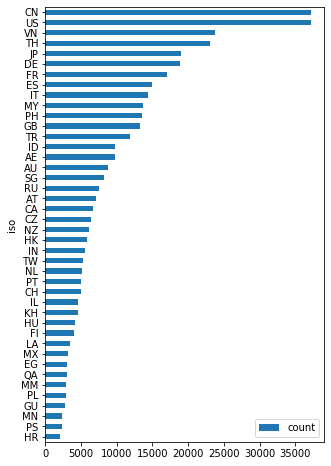

In [302]:
gi.set_index('iso').plot(kind='barh', figsize=(5,8))

In [303]:
# # index 리셋
# pivoted_roam.reset_index(inplace=True)
# # 결측치 0으로 대체
# pivoted_roam.fillna(0, inplace=True)

In [304]:
#pivoted_roam.set_index('Date', inplace=True)
new_roam = pivoted_roam[extracted_countrys]

# 4. 데이터 결합

In [305]:
df = pd.merge(pivoted_kag, new_roam, on='Date', suffixes=('_conf', '_roam'))

In [306]:
df.set_index('Date',inplace=True)

In [307]:
# 로밍데이터에는 있지만 글로벌 데이터에는 없거나, 반대인 경우는 삭제
del_cols = []
cols = list(df.columns)
for col in cols:
    if (col.find('_conf')  == -1 and col.find('_roam') == -1):
        if col != 'KR':
            del_cols.append(col)

In [308]:
del_cols[:5]

['BS', 'BO', 'BN', 'CF', 'KM']

In [309]:
df.drop(del_cols, axis=1, inplace=True)

In [310]:
df = df.astype(int)

In [261]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 105 entries, 2020-01-22 to 2020-05-05
Data columns (total 79 columns):
MM_conf    105 non-null int32
LA_conf    105 non-null int32
NL_conf    105 non-null int32
PH_conf    105 non-null int32
RU_conf    105 non-null int32
KR         105 non-null int32
TW_conf    105 non-null int32
US_conf    105 non-null int32
AE_conf    105 non-null int32
GB_conf    105 non-null int32
VN_conf    105 non-null int32
AU_conf    105 non-null int32
AT_conf    105 non-null int32
KH_conf    105 non-null int32
CA_conf    105 non-null int32
CN_conf    105 non-null int32
HR_conf    105 non-null int32
CZ_conf    105 non-null int32
EG_conf    105 non-null int32
FI_conf    105 non-null int32
FR_conf    105 non-null int32
DE_conf    105 non-null int32
HU_conf    105 non-null int32
IN_conf    105 non-null int32
ID_conf    105 non-null int32
IL_conf    105 non-null int32
IT_conf    105 non-null int32
JP_conf    105 non-null int32
MY_conf    105 non-null int32
MX_con

# 뉴스

In [311]:
news = pd.read_csv("./data/corona_news.csv")

In [312]:
news = news[:-4]
news.rename(columns={'date':'Date', 'counts':'news'},inplace=True)
news.Date = pd.to_datetime(news.Date)

In [313]:
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 2 columns):
Date    107 non-null datetime64[ns]
news    107 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.8 KB


In [314]:
df.tail()

,MM_conf,LA_conf,NL_conf,PH_conf,RU_conf,KR,TW_conf,US_conf,AE_conf,GB_conf,...,MY_roam,IT_roam,ES_roam,FR_roam,DE_roam,JP_roam,TH_roam,VN_roam,US_roam,CN_roam
Date,,,,,,,,,,,,,,,,,,,,,
2020-05-01,0,0,476,284,7933,6,0,34037,557,6204,...,3,3,0,3,4,98,22,43,52,153
2020-05-02,0,0,445,156,9623,13,3,29078,561,4815,...,6,6,6,9,31,155,15,15,108,85
2020-05-03,4,0,335,295,10633,8,4,25501,564,4342,...,0,6,3,3,15,154,20,48,116,146
2020-05-04,6,0,199,262,10581,3,2,22335,567,3990,...,0,3,0,15,32,131,12,91,72,97
2020-05-05,0,0,318,199,10102,2,0,23976,462,4411,...,3,0,0,0,15,155,23,40,119,91


In [315]:
df.reset_index(inplace=True)
df = pd.merge(df, news, on='Date')

# 구글 트렌드 데이터

In [280]:
trend = pd.read_csv("./data/구글트렌드.csv")

In [317]:
trend=trend[['Date', 'covid_tr', 'coro_tr']]

In [319]:
trend.Date = pd.to_datetime(trend.Date)

C:\Users\Joshua\Anaconda3\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [321]:
df = pd.merge(df, trend, on='Date')

# 국내 해외 유입 일별 확진자 데이터 병합

In [322]:
ov = pd.read_csv('./data/oversea_inflow.csv')

In [323]:
ov = ov[1:-1]

In [324]:
ov = ov.iloc[:,0:2]

In [325]:
ov.rename(columns={'date':'Date', 'oversea_inflow':'target'}, inplace=True)
ov['Date'] = pd.to_datetime(ov['Date'])

In [326]:
df = pd.merge(df, ov, on='Date')

In [327]:
df.target = df.target.astype(int)

In [328]:
df['target'] = df['target'].diff()

In [329]:
df['target'].iloc[0] = 0

C:\Users\Joshua\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [333]:
df.tail()

,Date,MM_conf,LA_conf,NL_conf,PH_conf,RU_conf,KR,TW_conf,US_conf,AE_conf,...,DE_roam,JP_roam,TH_roam,VN_roam,US_roam,CN_roam,news,covid_tr,coro_tr,target
100,2020-05-01,0,0,476,284,7933,6,0,34037,557,...,4,98,22,43,52,153,1104.0,48.0,18.0,8.0
101,2020-05-02,0,0,445,156,9623,13,3,29078,561,...,31,155,15,15,108,85,732.0,43.0,18.0,8.0
102,2020-05-03,4,0,335,295,10633,8,4,25501,564,...,15,154,20,48,116,146,821.0,55.0,18.0,10.0
103,2020-05-04,6,0,199,262,10581,3,2,22335,567,...,32,131,12,91,72,97,1331.0,30.0,17.0,8.0
104,2020-05-05,0,0,318,199,10102,2,0,23976,462,...,15,155,23,40,119,91,793.0,30.0,17.0,3.0


In [332]:
df.covid_tr.iloc[-1] = 30
df.coro_tr.iloc[-1] = 17

In [334]:
df.to_csv('./data/final_0507.csv')